In [45]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

In [46]:
# Get data file path
file_name = 'df_fuel_ckan.csv'
file_path = os.path.join(os.getcwd(), 'data', file_name)
file_path

'/Users/jinrhee/Desktop/Oxford/Engineering Science/2024-25/B Papers/B1 Engineering Computation/B1 Project Sustainable Computing/Sustainable Computing/data/df_fuel_ckan.csv'

In [47]:
# csv file has 
df = pd.read_csv(file_path)

carbon_data = pd.DataFrame(df['CARBON_INTENSITY'].values, index=pd.to_datetime(df['DATETIME']))
annual_carbon = carbon_data.resample('YE').mean()
monthly_carbon = carbon_data.resample('ME').mean()
daily_carbon = carbon_data.resample('D').mean()
hourly_carbon = carbon_data.resample('h').mean()

# Truncate data after 2023-12-31 23:59:59
start_date = pd.Timestamp('2023-11-30 23:59:59').tz_localize('UTC')
stop_date = pd.Timestamp('2023-12-31 23:59:59').tz_localize('UTC')
annual_carbon = annual_carbon.truncate(after=stop_date)
monthly_carbon = monthly_carbon.truncate(after=stop_date)
daily_carbon = daily_carbon.truncate(after=stop_date)
hourly_carbon = hourly_carbon.truncate(after=stop_date)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.50290D+00    |proj g|=  2.75402D-02

At iterate    5    f=  4.49176D+00    |proj g|=  3.71047D-02

At iterate   10    f=  4.47712D+00    |proj g|=  1.69502D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   4.146D-06   4.477D+00
  F =   4.4771193352599843     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
MSE: 916.5922474355208
RMSE: 30.275274522876266


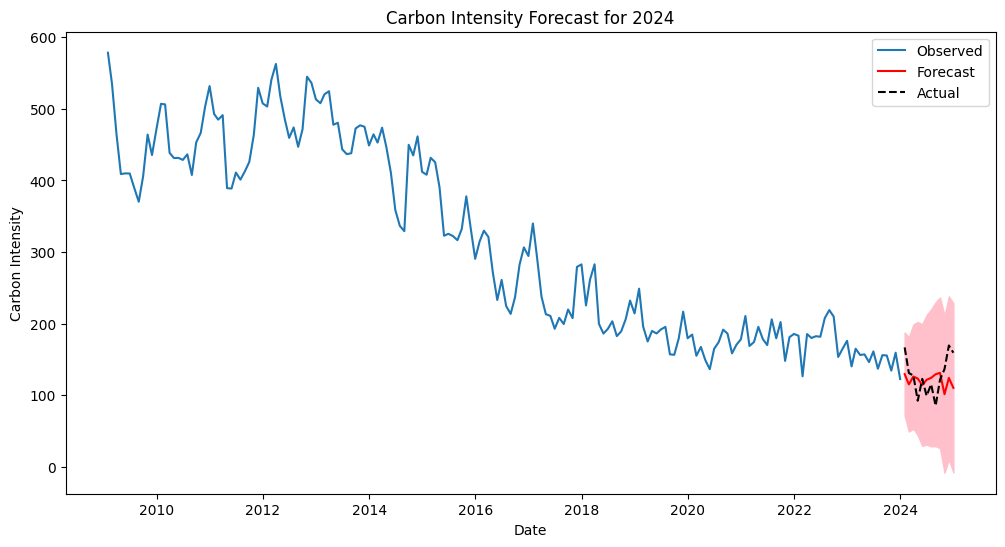

In [278]:
# Define SARIMA parameters
p, d, q = 0, 1, 1
P, D, Q, s = 0, 1, 1, 12  # Assuming monthly seasonality

# Fit the SARIMA model using data up to the end of 2023
model = SARIMAX(monthly_carbon, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

# Forecast the carbon intensity values for the 12 months of 2024
forecast_periods = 12
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean

# Evaluate the forecast with the actual monthly carbon data in 2024
cutoff = pd.Timestamp('2024-01-01 00:00:00').tz_localize('UTC')
observed = carbon_data.resample('ME').mean().truncate(before=cutoff, after=cutoff + pd.DateOffset(months=12))

# Calculate MSE and RMSE
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_carbon, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.plot(observed, 'k--', label='Actual')
plt.fill_between(forecast.conf_int().index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='pink')
plt.title("Carbon Intensity Forecast for 2024")
plt.xlabel("Date")
plt.ylabel("Carbon Intensity")
plt.legend()
plt.show()

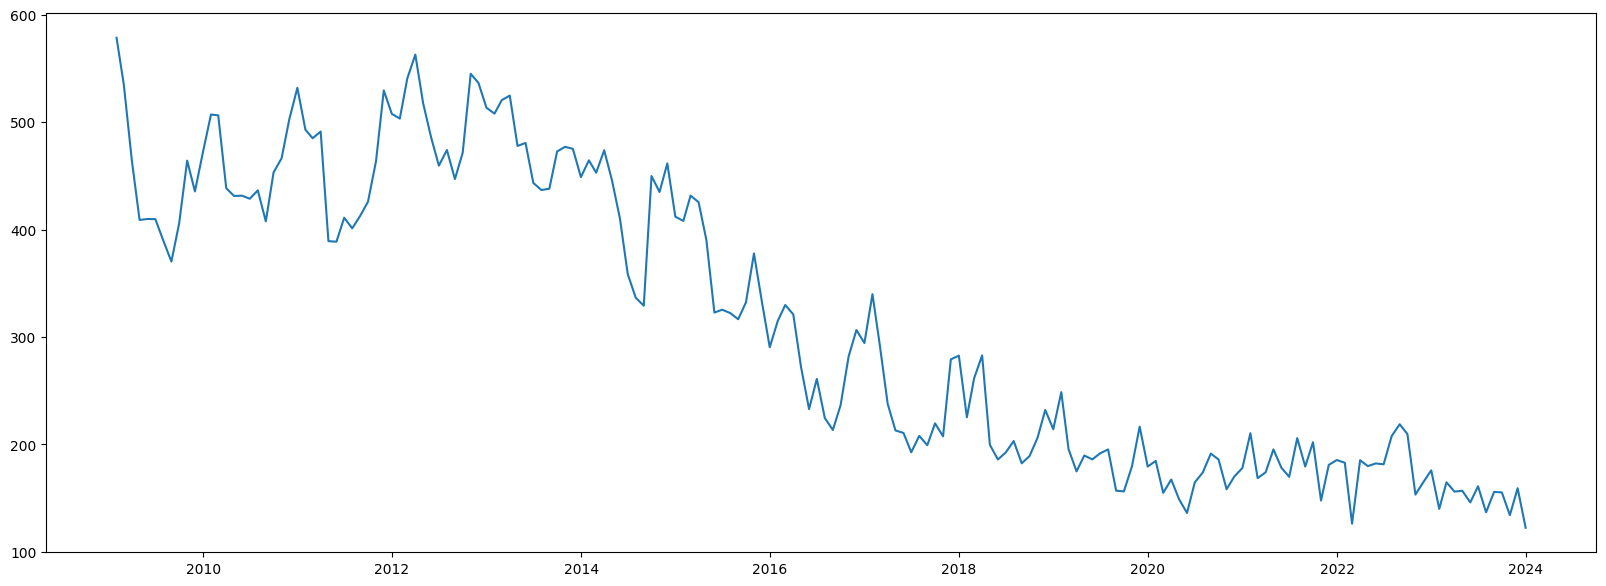

In [245]:
plt.figure(figsize=(20, 7))
plt.plot(monthly_carbon)
plt.show()

In [48]:
# Check stationarity (from https://www.geeksforgeeks.org/sarima-seasonal-autoregressive-integrated-moving-average/)
def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')

def diff(timeseries, num):
    diff_timeseries = timeseries.diff(periods=num)
    diff_timeseries.dropna(inplace=True)
    return diff_timeseries

def diff_n(timeseries, num, n):
    # carry out diff() n times
    for _ in range(n):
        diff_timeseries = diff(timeseries, num)
    return diff_timeseries


ADF Statistic: -2.0014400548592466
p-value: 0.2859420424824646
Non-Stationary
ADF Statistic: -19.26022686486683
p-value: 0.0
Stationary
ADF Statistic: -19.26022686486683
p-value: 0.0
Stationary
ADF Statistic: -19.26022686486683
p-value: 0.0
Stationary


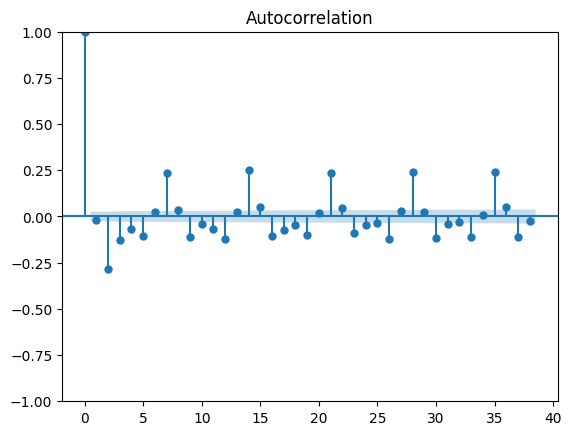

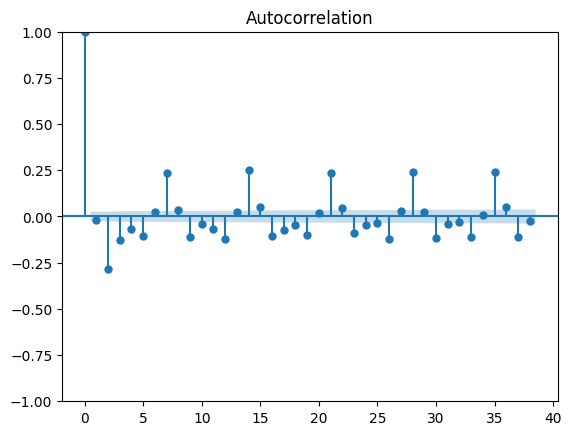

In [31]:
# Check difference parameter for daily
diff_1 = diff(daily_carbon, 1)
diff_2 = diff_n(daily_carbon, 1, 2)
diff_3 = diff_n(daily_carbon, 1, 3)

check_stationarity(daily_carbon)
check_stationarity(diff_1)
check_stationarity(diff_2)
check_stationarity(diff_3)

plot_acf(diff_1)

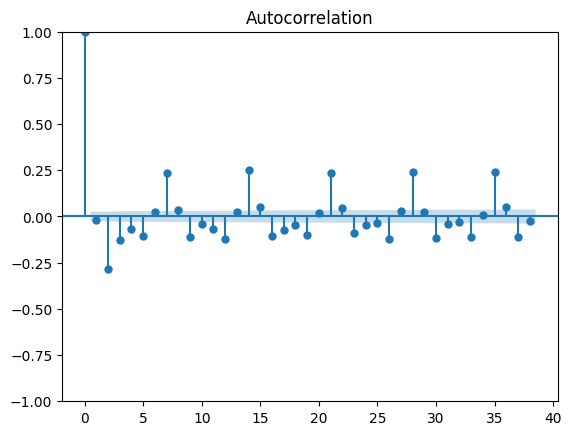

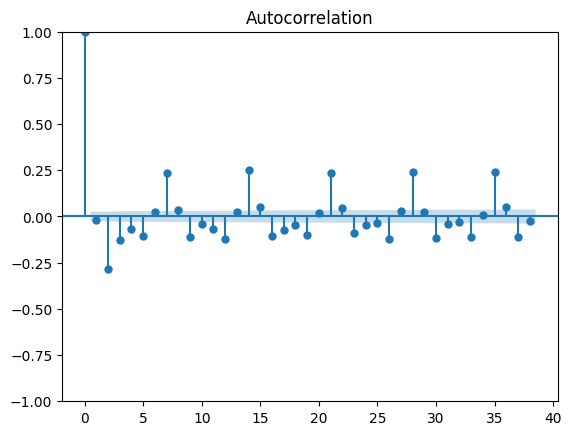

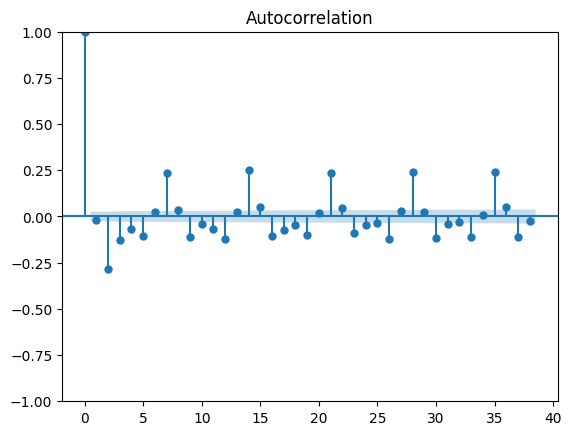

ADF Statistic: -2.9743467812941766
p-value: 0.03736053377062478
Stationary
ADF Statistic: -2.9743467812941766
p-value: 0.03736053377062478
Stationary
ADF Statistic: -2.9743467812941766
p-value: 0.03736053377062478
Stationary


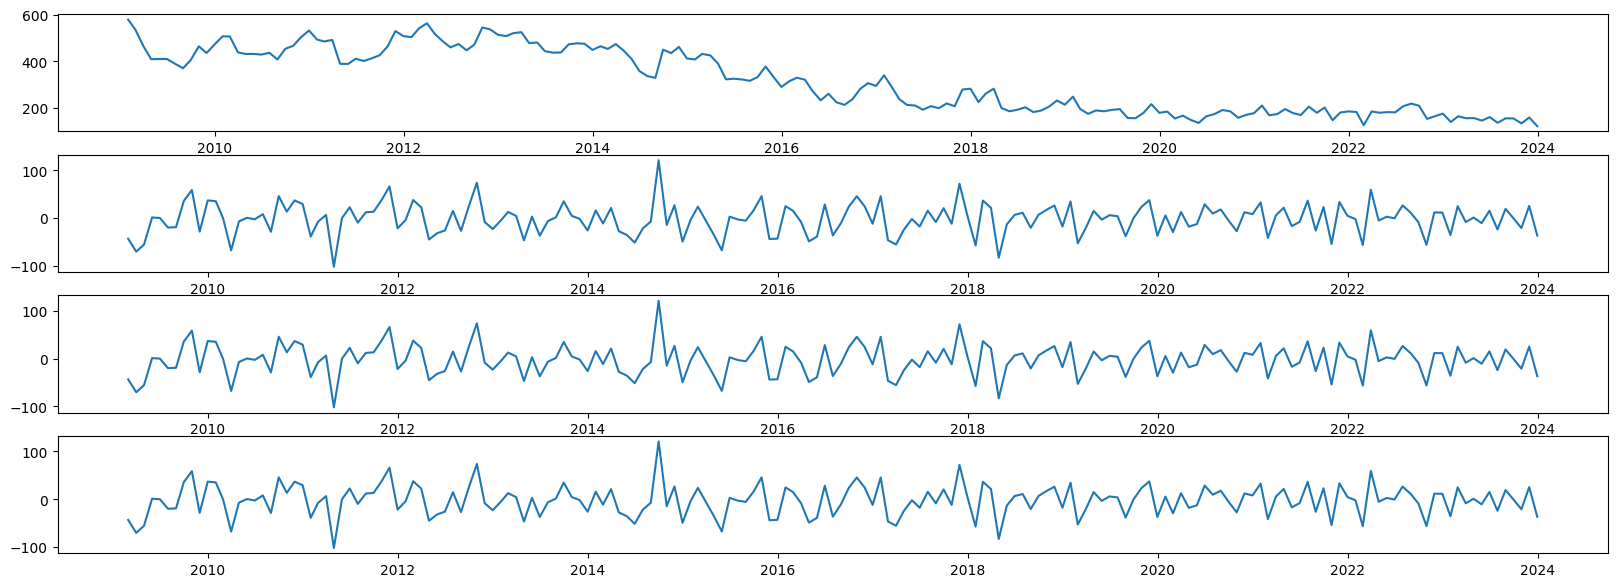

In [247]:
# Check difference parameter
diff_1 = diff(monthly_carbon, 1)
diff_2 = diff_n(monthly_carbon, 1, 2)
diff_3 = diff_n(monthly_carbon, 1, 3)

check_stationarity(diff_1)
check_stationarity(diff_2)
check_stationarity(diff_3)

fig, ax = plt.subplots(4, 1, figsize=(20, 7))
ax[0].plot(monthly_carbon)
ax[1].plot(diff_1)
ax[2].plot(diff_2)
ax[3].plot(diff_3)

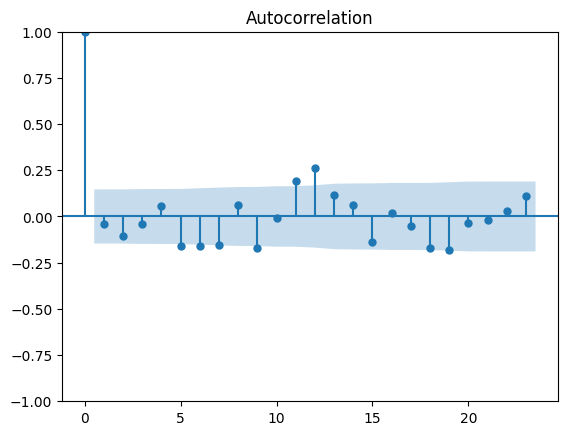

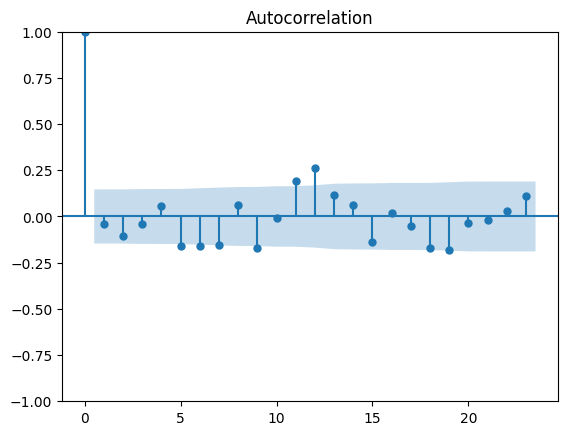

In [249]:
plot_acf(diff_1)

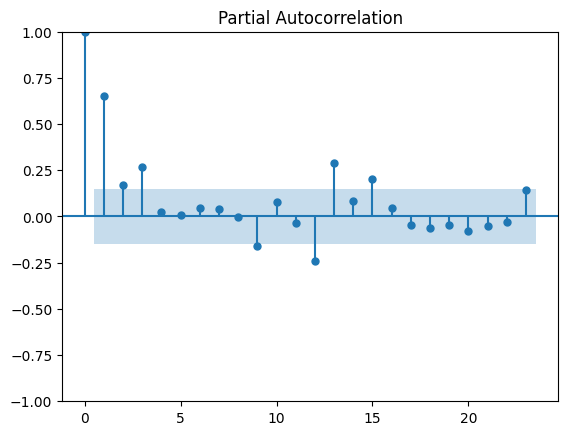

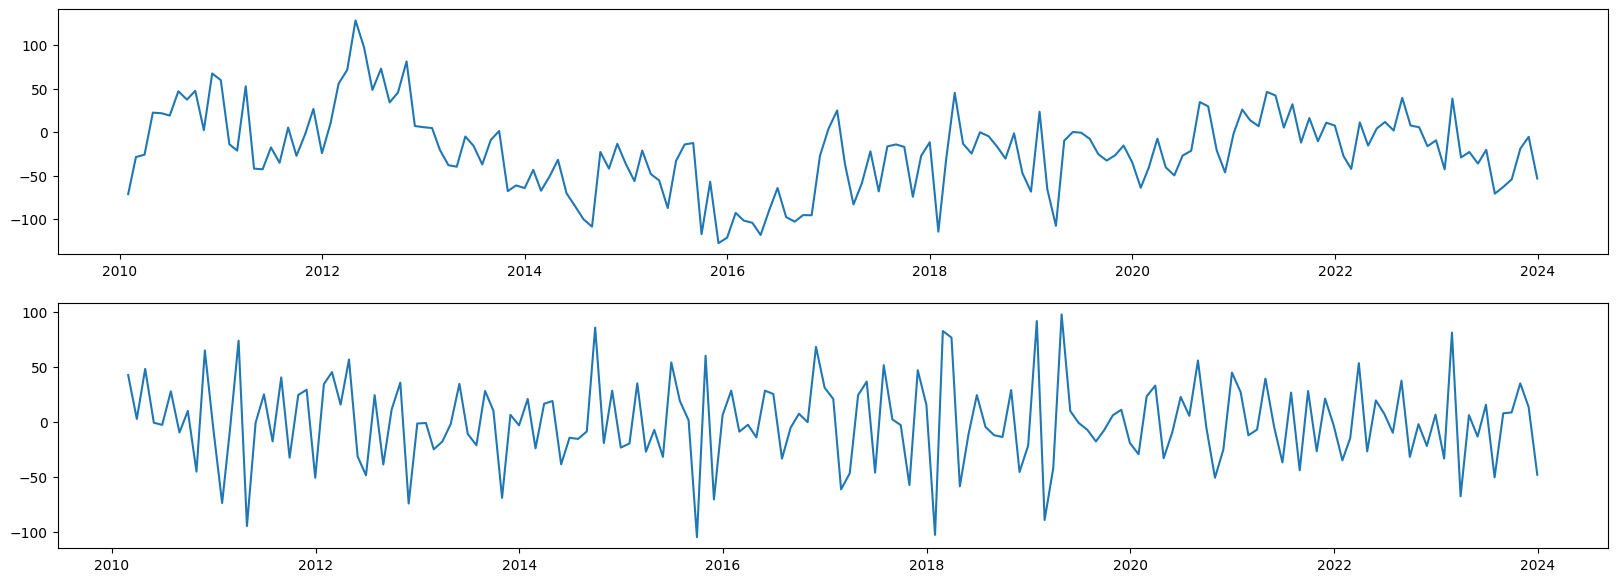

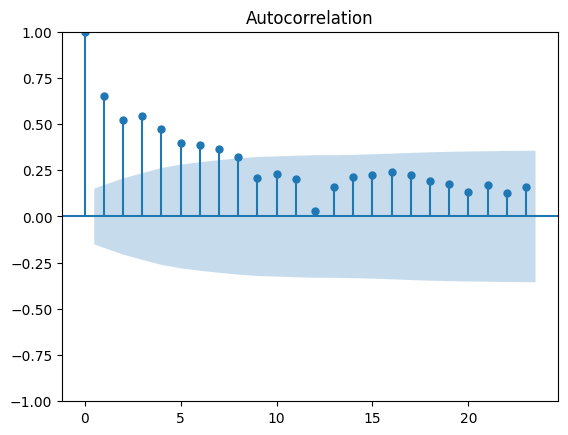

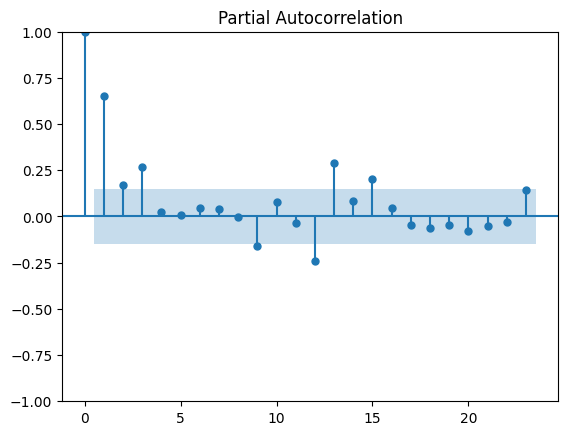

In [265]:
# Seasonal difference
season_diff = diff(monthly_carbon, 12)
season_diff_1 = diff(season_diff, 1)

fig, ax = plt.subplots(2, 1, figsize=(20, 7))
ax[0].plot(season_diff)
ax[1].plot(season_diff_1)

plot_acf(season_diff)
plot_pacf(season_diff)

In [267]:
results_arr = []

# From (https://www.geeksforgeeks.org/sarima-seasonal-autoregressive-integrated-moving-average/)
# Define SARIMA parameters
p, d, q = 0, 1, 0
P, D, Q, s = 0, 1, 0, 12  # Assuming monthly seasonality

# Fit the SARIMA model
model = SARIMAX(monthly_carbon, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

results_arr.append(results)

# Define SARIMA parameters
p, d, q = 0, 1, 1
P, D, Q, s = 0, 1, 1, 12  # Assuming monthly seasonality

# Fit the SARIMA model
model = SARIMAX(monthly_carbon, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

results_arr.append(results)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.69646D+00    |proj g|=  1.96512D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   1.203D-06   4.695D+00
  F =   4.6951217241858068     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.5

 This problem is unconstrained.
 This problem is unconstrained.


In [273]:
cutoff = pd.Timestamp('2024-01-01 00:00:00').tz_localize('UTC')
observed = carbon_data.resample('ME').mean().truncate(before=cutoff)

forecast_periods = 12
for results in results_arr:
    forecast = results.get_forecast(steps=forecast_periods)
    forecast_mean = forecast.predicted_mean
    mae = mean_absolute_error(observed, forecast_mean)
    mse = mean_squared_error(observed, forecast_mean)
    rmse = root_mean_squared_error(observed, forecast_mean)
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print()


MAE: 37.70152610004525
MSE: 2122.956365689753
RMSE: 46.07555062817755

MAE: 25.73328747041825
MSE: 916.5922474355208
RMSE: 30.275274522876266



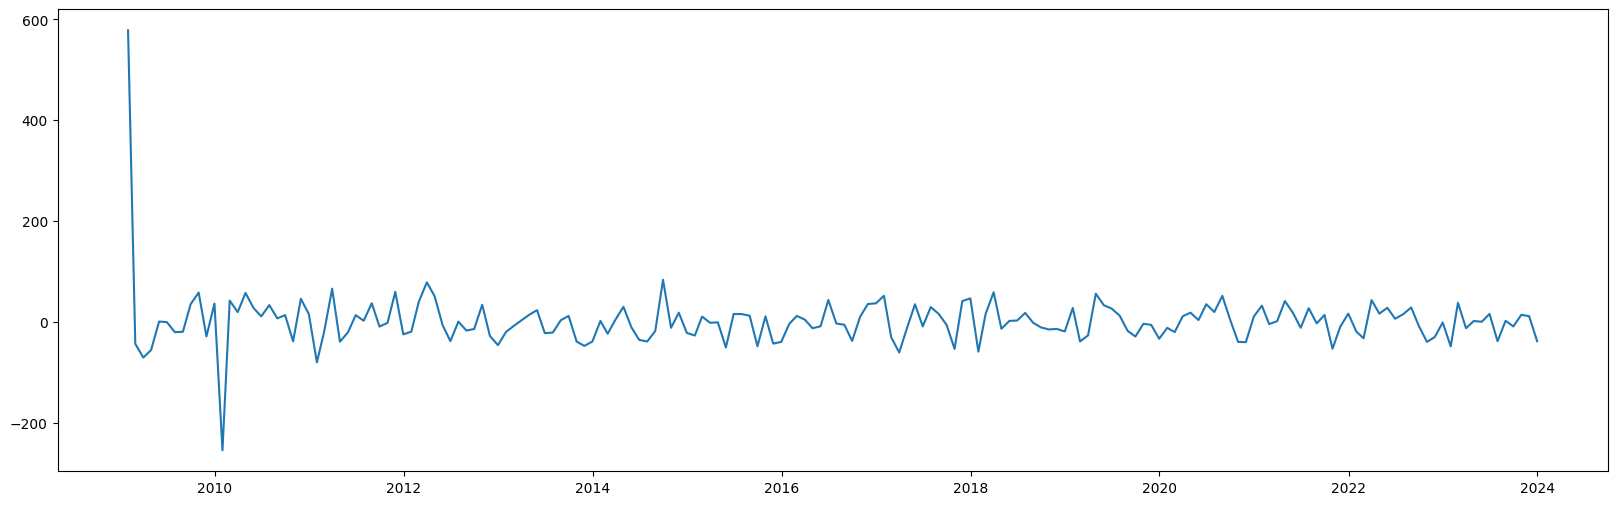

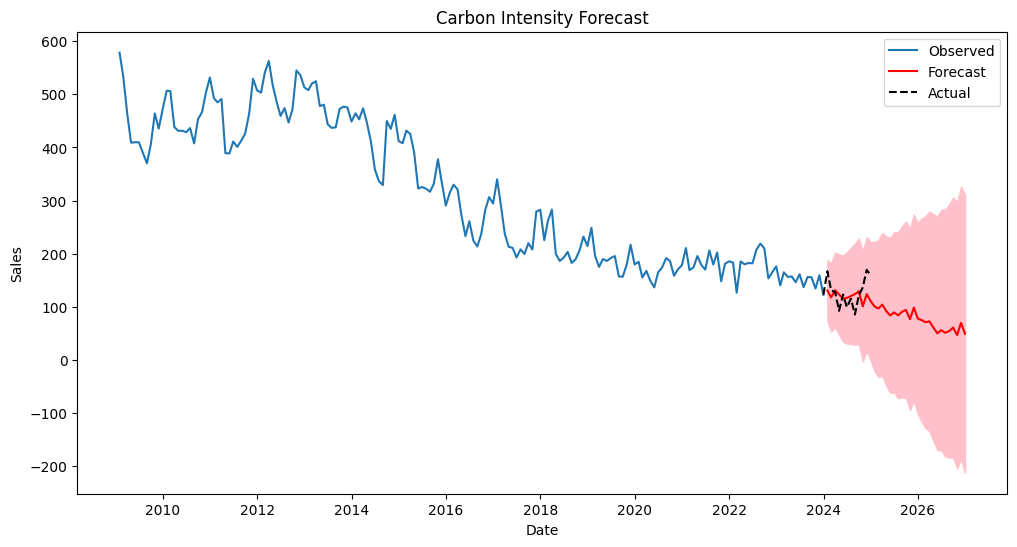

In [262]:
# from https://www.geeksforgeeks.org/sarima-seasonal-autoregressive-integrated-moving-average/
# Forecast future values
forecast_periods = 36  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
residuals = results.resid
plt.figure(figsize=(20, 6))
plt.plot(residuals)
plt.show()
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_carbon, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.plot(carbon_data.resample('ME').mean().truncate(before=start_date), 'k--', label='Actual')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Carbon Intensity Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

Daily carbon intensity data

In [197]:
# Figuring out order of differencing
# d=0
check_stationarity(daily_carbon)
# d=1
diff_1 = diff(daily_carbon, 1)
check_stationarity(diff_1)
#d=2
diff_2 = diff_n(daily_carbon, 1, 2)
check_stationarity(diff_2)
#d=3
diff_3 = diff_n(daily_carbon, 1, 3)
check_stationarity(diff_3)

ADF Statistic: -2.0014400548592466
p-value: 0.2859420424824646
Non-Stationary
ADF Statistic: -19.26022686486683
p-value: 0.0
Stationary
ADF Statistic: -19.26022686486683
p-value: 0.0
Stationary
ADF Statistic: -19.26022686486683
p-value: 0.0
Stationary


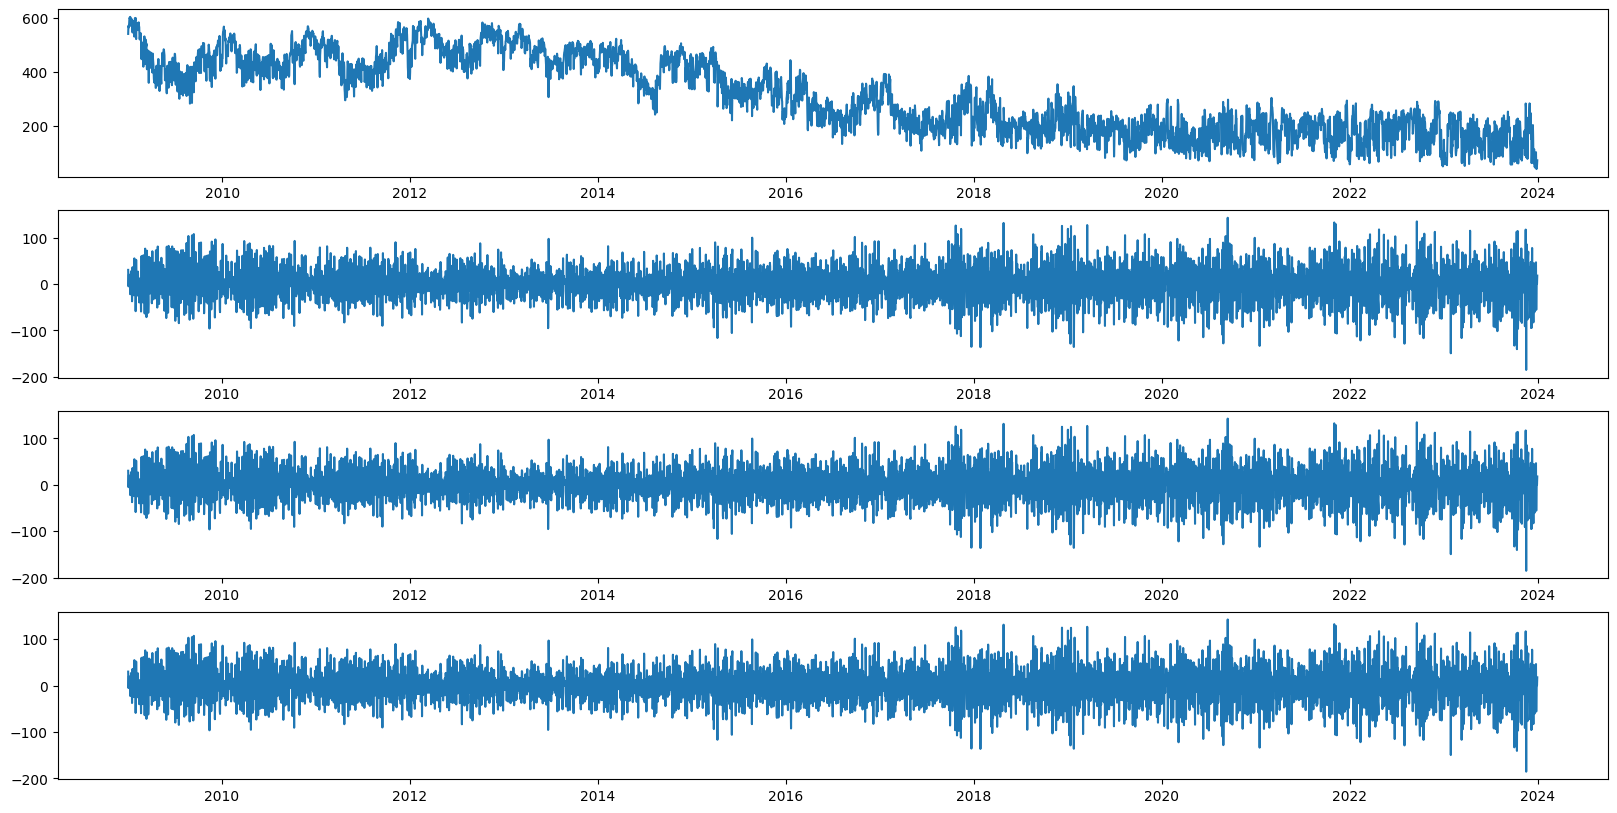

In [237]:
fig, ax = plt.subplots(4, 1, figsize=(20, 10))
ax[0].plot(daily_carbon)
ax[1].plot(diff_1)      # diff_1 already looks like white noise
ax[2].plot(diff_2)
ax[3].plot(diff_3)

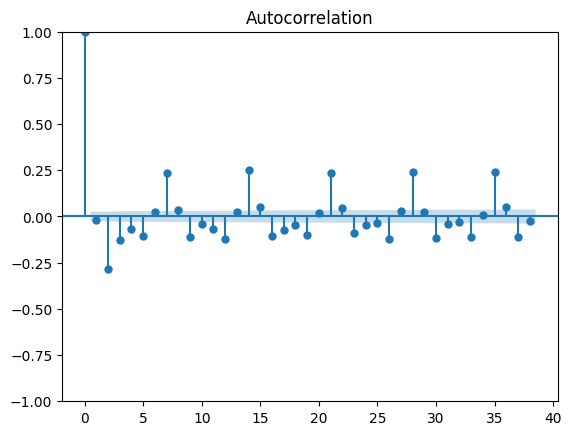

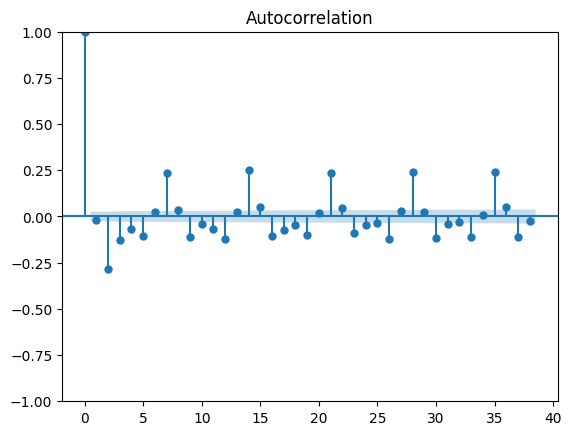

In [238]:
plot_acf(diff_1)

Note periodicity in autocorrelation function with period of 7

ADF Statistic: -17.011621052137
p-value: 8.583138783707215e-30
Stationary
ADF Statistic: -25.596515247900218
p-value: 0.0
Stationary


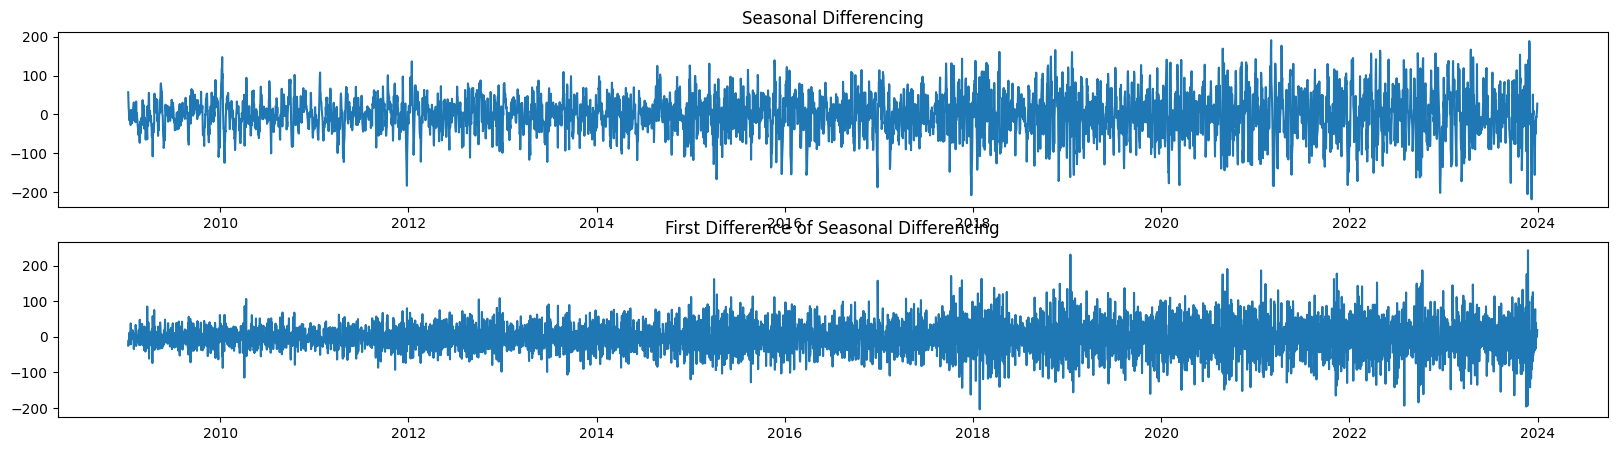

In [239]:
# Check seasonal differencing
season_diff = diff(daily_carbon, 7)
check_stationarity(season_diff)
fig, ax = plt.subplots(2, 1, figsize=(20, 5))
ax[0].plot(season_diff)
ax[0].set_title('Seasonal Differencing')

# First difference of seasonal difference
season_diff_1 = diff(season_diff, 1)
check_stationarity(season_diff_1)
ax[1].plot(season_diff_1)
ax[1].set_title('First Difference of Seasonal Differencing')
plt.show()

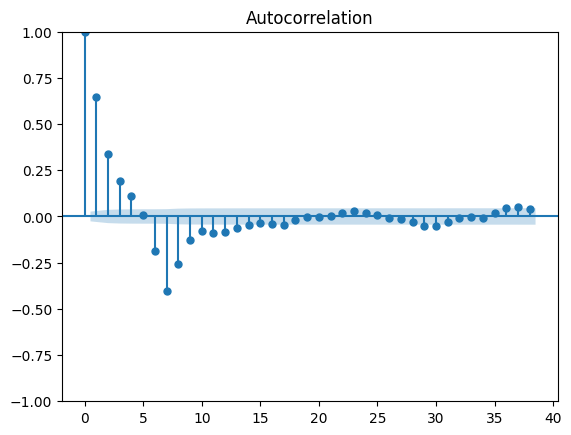

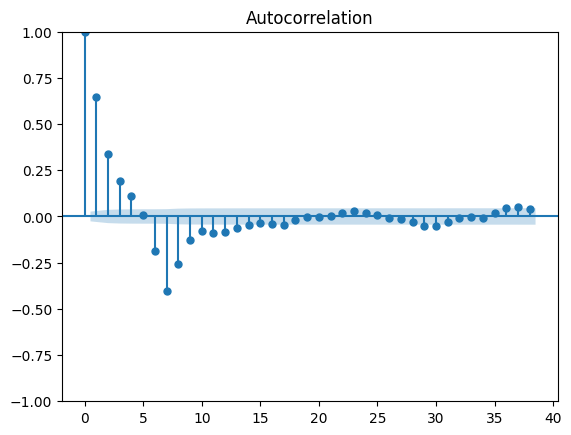

In [240]:
plot_acf(season_diff)

In [215]:
# From (https://www.geeksforgeeks.org/sarima-seasonal-autoregressive-integrated-moving-average/)
# Define SARIMA parameters
p, d, q = 0, 1, 1
P, D, Q, s = 0, 1, 1, 28  # Seasonal differencing order of 2

# Fit the SARIMA model
model = SARIMAX(daily_carbon, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()
#model

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.97791D+00    |proj g|=  4.08888D-02

At iterate    5    f=  4.93862D+00    |proj g|=  1.00621D-02

At iterate   10    f=  4.87487D+00    |proj g|=  2.99831D-05

At iterate   15    f=  4.87287D+00    |proj g|=  1.04322D-02

At iterate   20    f=  4.87198D+00    |proj g|=  5.46407D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     35      1     0     0   5.464D-06   4.872D+00
  F =   4.8719795388652898     

CONVERG

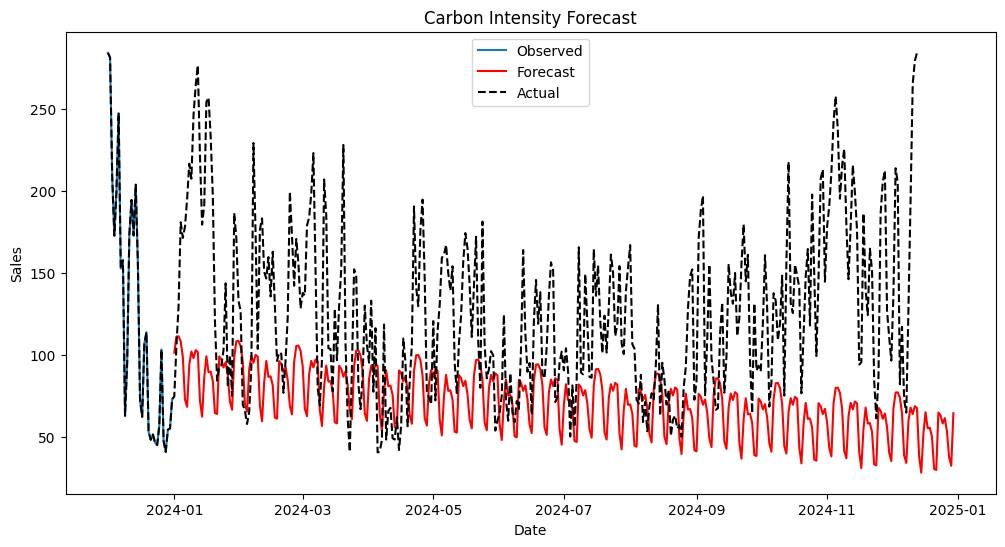

In [216]:
# from https://www.geeksforgeeks.org/sarima-seasonal-autoregressive-integrated-moving-average/
# Forecast future values
forecast_periods = 365  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(daily_carbon.truncate(before=start_date), label='Observed')
plt.plot(forecast_mean.truncate(before=start_date), label='Forecast', color='red')
plt.plot(carbon_data.resample('D').mean().truncate(before=start_date), 'k--', label='Actual')
#plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Carbon Intensity Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

In [156]:
observed = carbon_data.resample('D').mean().truncate(before=stop_date)
print(observed.tail())
print(forecast_mean.tail())
#mae = mean_absolute_error(observed, forecast_mean)
#mse = mean_squared_error(observed, forecast_mean)
#print(f'MAE: {mae}')
#print(f'MSE: {mse}')

                                    0
DATETIME                             
2024-12-09 00:00:00+00:00  128.083333
2024-12-10 00:00:00+00:00  194.625000
2024-12-11 00:00:00+00:00  265.312500
2024-12-12 00:00:00+00:00  279.520833
2024-12-13 00:00:00+00:00  284.450000
2024-12-26 00:00:00+00:00    510.648527
2024-12-27 00:00:00+00:00    521.671330
2024-12-28 00:00:00+00:00    521.349645
2024-12-29 00:00:00+00:00    533.599200
2024-12-30 00:00:00+00:00    553.818985
Freq: D, Name: predicted_mean, dtype: float64
